# Kaggle Competition: Toxic Comment Classification

This Jupyter Notebook outlines the approach to build a multi-headed model for the Kaggle competition, which involves predicting different types of comment toxicity.

## Import Required Libraries

In [16]:
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud,  STOPWORDS
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Load Data

In [17]:
train_path = '../src/data/train.csv'
test_path = '../src/data/test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

## Distribution of Toxicity Classes

The following bar chart shows the distribution of different types of toxicity in the dataset. This visualization helps in understanding the prevalence of each type of toxicity within the comments. Such insights are crucial for tailoring the model to better recognize and differentiate between these types.

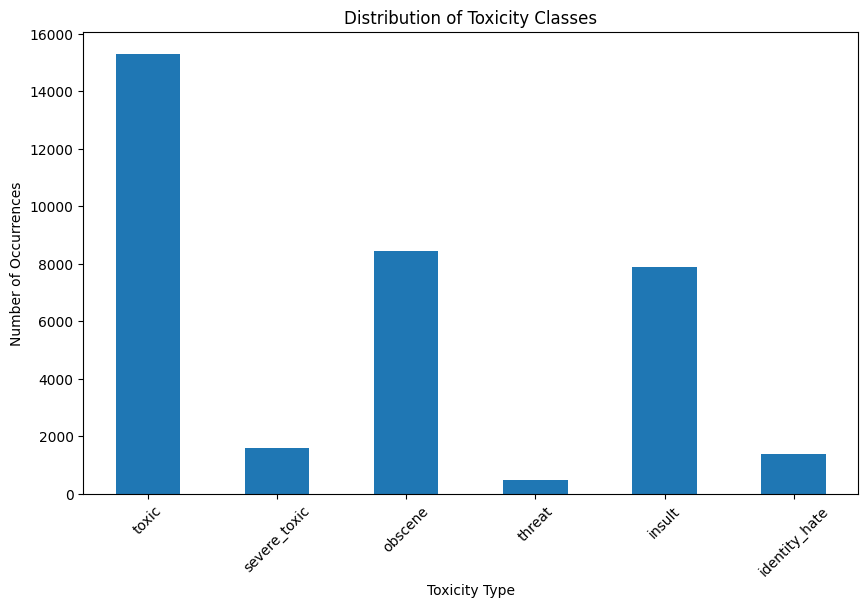

In [18]:
# Counting occurrences for each type of toxicity
counts = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

# Creating a bar chart
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.title('Distribution of Toxicity Classes')  # Title of the plot
plt.xlabel('Toxicity Type')                    # Label for the X-axis
plt.ylabel('Number of Occurrences')            # Label for the Y-axis
plt.xticks(rotation=45)                        # Rotate labels on X-axis for better readability
plt.show()                                     # Display the plot

## Words and Phrases Commonly Found in Each Class of Toxic Comments

The word cloud below visualizes the most frequent words found in each class of toxic comments. This visualization helps in identifying key themes and terms that are commonly associated with toxicity in the dataset. Such insights can be useful for understanding the nature of the toxic content and for further refining the model to better recognize toxic comments.


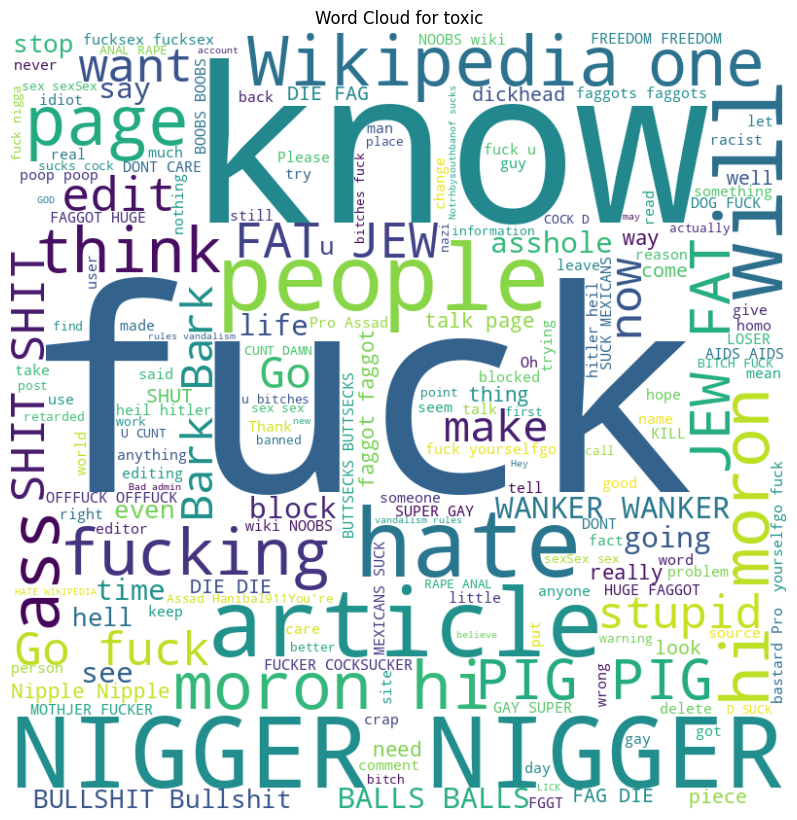

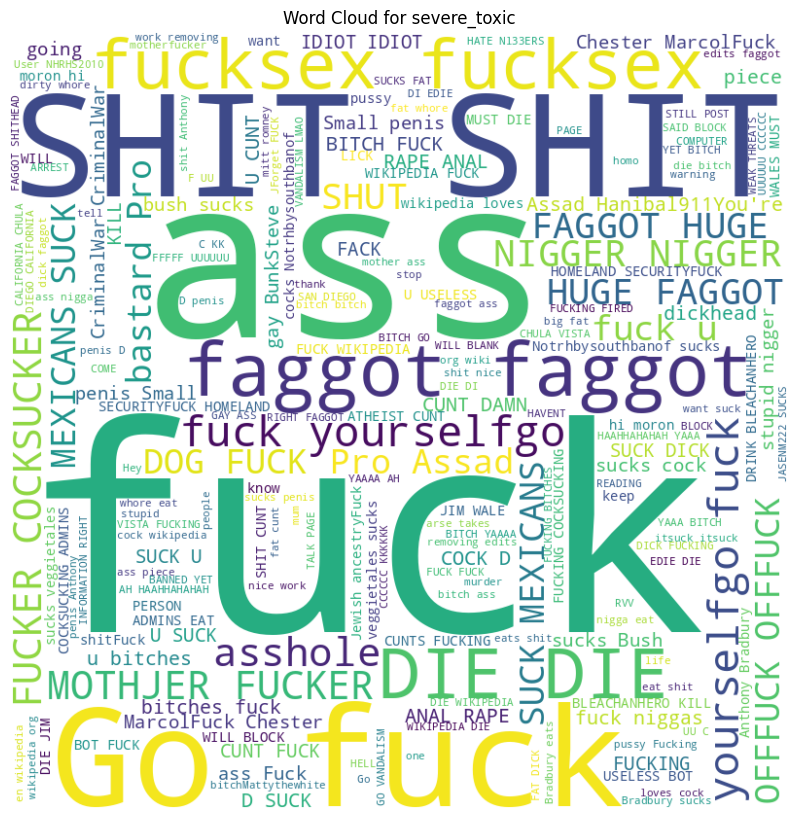

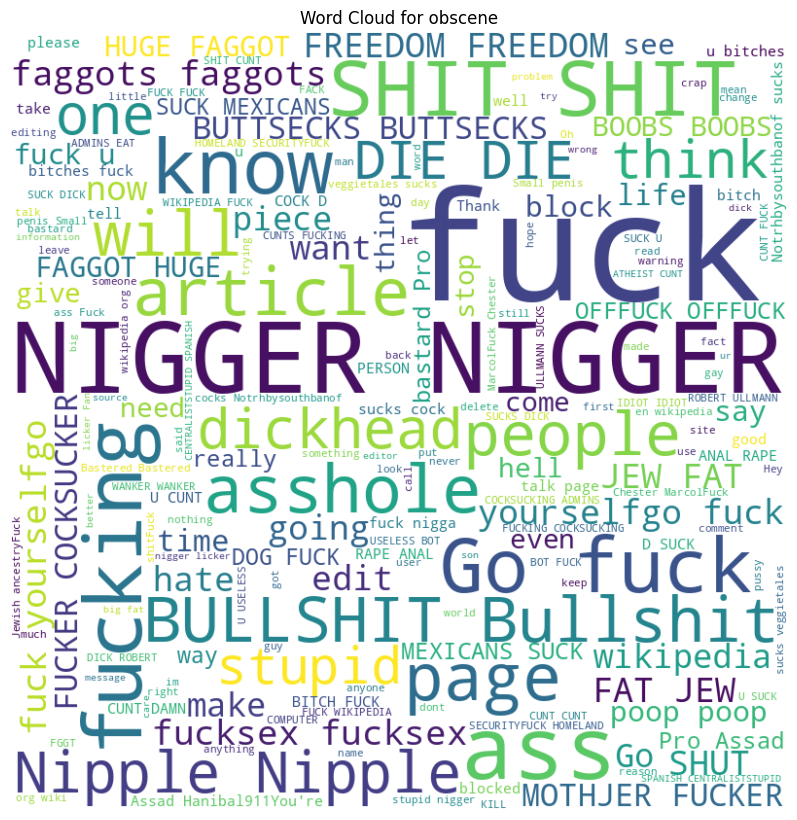

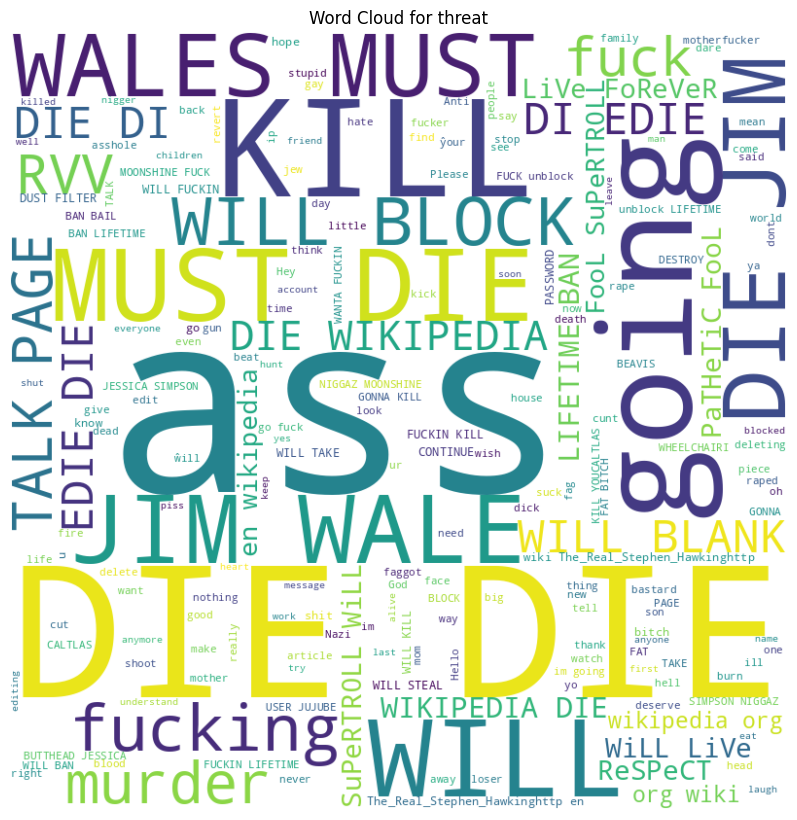

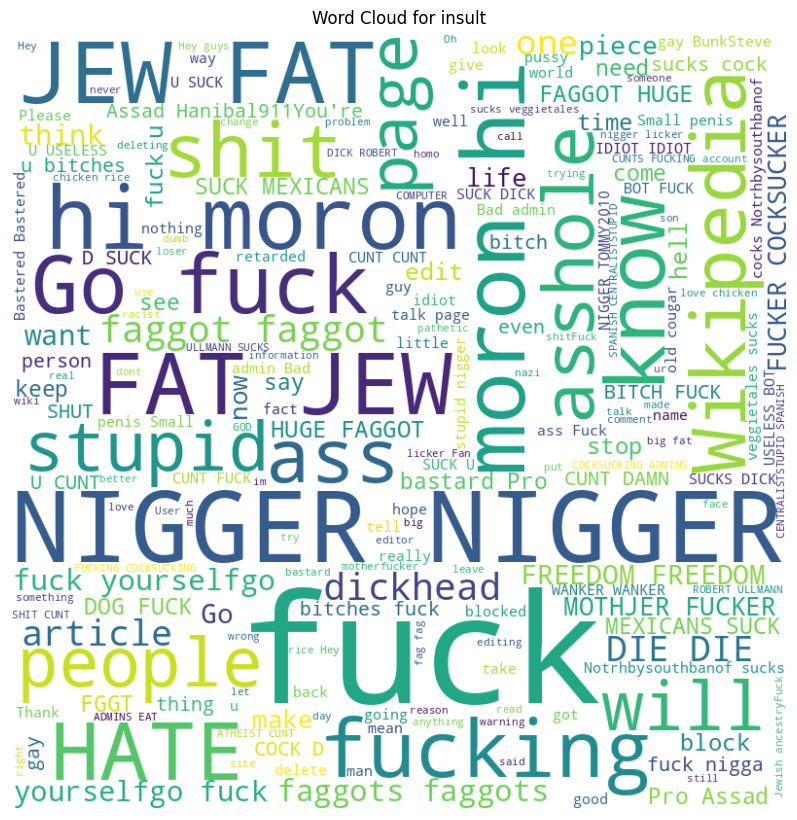

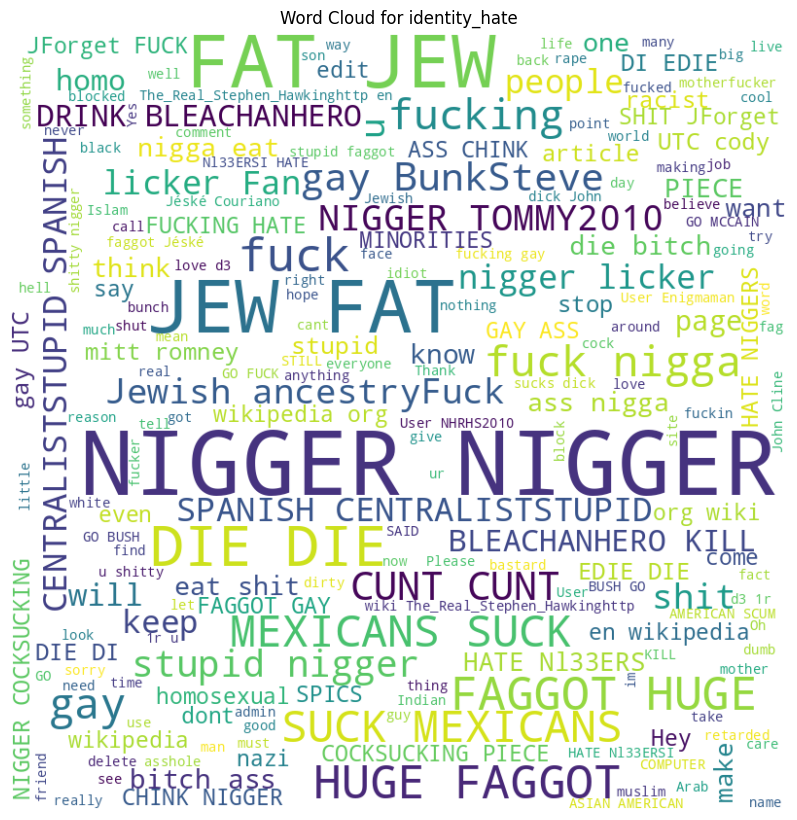

In [19]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
  # Combine all toxic comments into a single text string
  toxic_comments = train_data[train_data[label] == 1]['comment_text'].str.cat(sep=' ')

  # Create a word cloud
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = set(STOPWORDS), 
                  min_font_size = 10).generate(toxic_comments)

  # Visualize the word cloud
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f'Word Cloud for {label}')
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show()

## Correlation Between Different Types of Toxicity

The heatmap below shows the correlations between different types of toxicity in the dataset. This visualization is crucial to understand how these types of toxicity are related. For example, a high correlation between two types would suggest that they often occur together in the comments. Understanding these relationships can be useful for feature engineering and improving model performance.


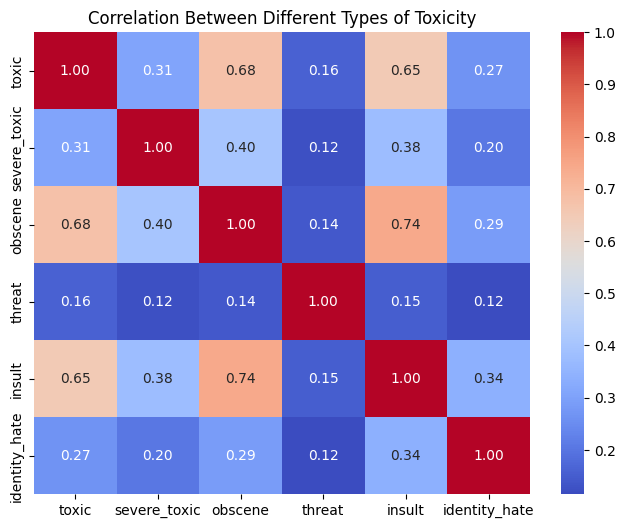

In [20]:
# Calculate the correlation matrix
correlation_matrix = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Different Types of Toxicity')
plt.show()

## Data Preprocessing

In [21]:
# Comments Length Before Cleaning
train_data['original_len'] = train_data['comment_text'].apply(len)

In [22]:
# Download stopwords and wordnet from NLTK
nltk.download('stopwords')
nltk.download('wordnet')
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove special characters and punctuation
    text = re.sub(r'\\W+', ' ', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

# Clean the text data
train_data['comment_text'] = train_data['comment_text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/80/slqg73_x62s055tz5zmhx1b40000gn/T/ipykernel_99942/3247480611.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/var/folders/80/slqg73_x62s055tz5zmhx1b40000gn/T/ipykernel_99942/3247480611.py:9: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


## Visualization of the Distribution of the Length of Comments
Visualization of the distribution of the length of comments before and after cleaning the text

/var/folders/80/slqg73_x62s055tz5zmhx1b40000gn/T/ipykernel_99942/3247480611.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


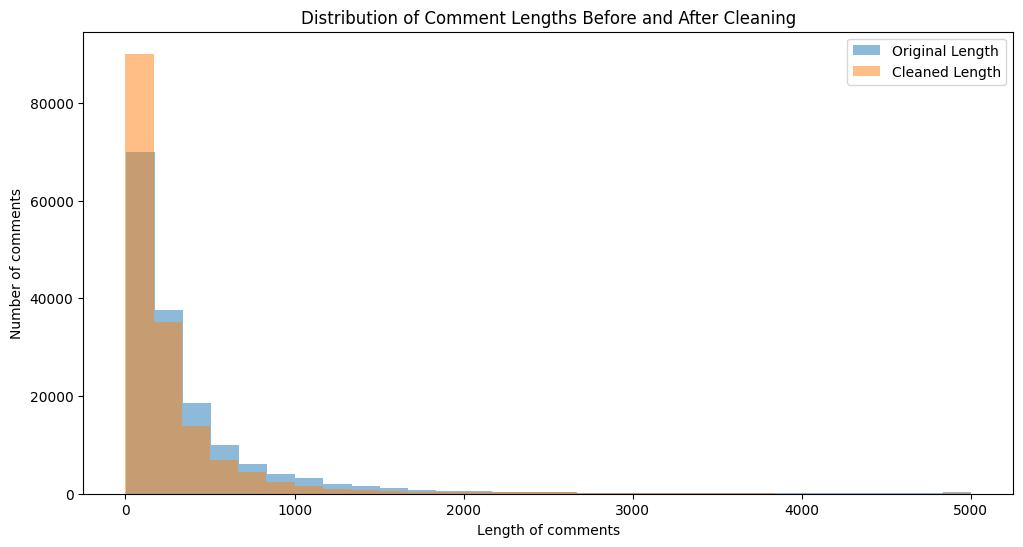

In [23]:
# Comments Length After cleaning
train_data['cleaned_len'] = train_data['comment_text'].apply(clean_text).apply(len)

plt.figure(figsize=(12, 6))

# Use a larger bin size for better visibility and adjust alpha for transparency
plt.hist(train_data['original_len'], bins=30, alpha=0.5, label='Original Length')
plt.hist(train_data['cleaned_len'], bins=30, alpha=0.5, label='Cleaned Length')

plt.title('Distribution of Comment Lengths Before and After Cleaning')
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')
plt.legend()
plt.show()


## Feature Engineering using TF-IDF

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['comment_text'])

## Visualization of TF-IDF distribution
Visualization of the distribution of the most important words (according to TF-IDF) in the dataset.

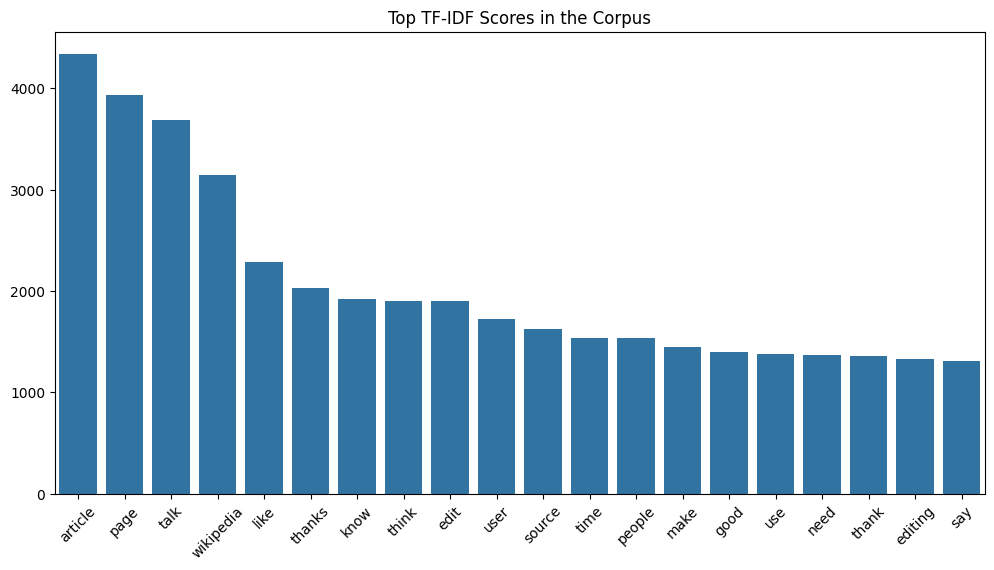

In [25]:
tfidf_scores = np.array(X_train_tfidf.sum(axis=0)).ravel()
tfidf_ranking = np.argsort(tfidf_scores)[::-1]
top_n = 20  # Top 20 words
top_features = [tfidf_vectorizer.get_feature_names_out()[i] for i in tfidf_ranking[:top_n]]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_features, y=tfidf_scores[tfidf_ranking[:top_n]])
plt.title('Top TF-IDF Scores in the Corpus')
plt.xticks(rotation=45)
plt.show()

## Model Building

In [26]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_full = train_data[labels]

# Split data into training and validation sets
X_train, X_val, y_train_split, y_val = train_test_split(X_train_tfidf, y_full, test_size=0.2, random_state=42)

# Initialize the model
model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

## Model Training and Validation

In [27]:
# Train the model
model.fit(X_train, y_train_split)

# Predict on the validation set
y_pred = model.predict_proba(X_val)

# Calculate ROC AUC score
roc_auc_scores = [roc_auc_score(y_val[label], y_pred[:, i]) for i, label in enumerate(labels)]
mean_roc_auc = np.mean(roc_auc_scores)
print('Mean Column-wise ROC AUC:', mean_roc_auc)

Mean Column-wise ROC AUC: 0.9747565769004467


## Hyperparameter Tuning

Hyperparameter tuning involves adjusting the parameters of the machine learning model to improve its performance. For Logistic Regression, a key hyperparameter to tune is the regularization strength (C). Regularization can help prevent overfitting. A lower value of C specifies stronger regularization.

We will use Grid Search technique for hyperparameter tuning

In [28]:
# Define the parameter grid
param_grid = {'estimator__C': [0.01, 0.1, 1, 10, 100]}

# Grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train_split)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'estimator__C': 1}


## Final Model Training and Predictions

Train the model on the entire dataset and make predictions on the test dataset.

In [29]:
# Retrain the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_tfidf, y_full)

# Preprocess the test data
test_data['comment_text'] = test_data['comment_text'].apply(clean_text)
X_test_tfidf = tfidf_vectorizer.transform(test_data['comment_text'])

# Make predictions
test_predictions = best_model.predict_proba(X_test_tfidf)


/var/folders/80/slqg73_x62s055tz5zmhx1b40000gn/T/ipykernel_99942/3247480611.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/var/folders/80/slqg73_x62s055tz5zmhx1b40000gn/T/ipykernel_99942/3247480611.py:9: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


## Preparing Submission File

Format the predictions as required for the competition submission

In [30]:
# Create a submission dataframe
submission = pd.DataFrame(test_predictions, columns=labels)
submission['id'] = test_data['id']
submission = submission[['id'] + labels]

# Save the submission file
submission.to_csv('../src/data/submission.csv', index=False)